# Traductor inglés-español basdado en NLP

Empecemos con un modelo sencillo que traducirá frases del inglés al español con base en el artículo [*Sequence to Sequence Learning with Neural Networks*](https://arxiv.org/abs/1409.3215)

In [28]:
import tensorflow as tf
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

### Descargar el dataset

Este conjunto de datos se compone de pares de frases creados por colaboradores del proyecto Tatoeba. Alrededor de 120.000 pares de frases fueron seleccionados por los autores del sitio web https://manythings.org/anki. Este conjunto de datos se publica bajo la licencia Creative CommonsAttribution 2.0 France. Hay otros pares de idiomas disponibles.

In [29]:
url = "https://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip"
path = tf.keras.utils.get_file("spa-eng.zip", origin=url, cache_dir="datasets",
                               extract=True)
text = (Path(path).with_name("spa-eng") / "spa.txt").read_text()

Cada línea contiene una frase en inglés y su correspondiente traducción al español, separadas por un tabulador. Empezaremos eliminando los caracteres españoles "¡" y "¿", que la capa de vectorización de texto no maneja, luego analizaremos los pares de frases y los barajaremos. Por último, las dividiremos en dos listas separadas, una por idioma.

In [30]:
text = text.replace("¡", "").replace("¿", "")  # Elimina los signos de exclamación e interrogación invertidos del texto.
pairs = [line.split("\t") for line in text.splitlines()]  # Divide el texto en líneas y luego cada línea en dos partes separadas por una tabulación, creando una lista de pares.

np.random.seed(42)
np.random.shuffle(pairs)  # Mezcla los pares de frases de manera aleatoria.
sentences_en, sentences_es = zip(*pairs)  # Separa los pares en dos listas: una para frases en inglés y otra para frases en español.

In [31]:
# Observemos 5 ejemplos
for i in range(5):
    print(sentences_en[i], "=>", sentences_es[i])

How boring! => Qué aburrimiento!
I love sports. => Adoro el deporte.
Would you like to swap jobs? => Te gustaría que intercambiemos los trabajos?
My mother did nothing but weep. => Mi madre no hizo nada sino llorar.
Croatia is in the southeastern part of Europe. => Croacia está en el sudeste de Europa.


A continuación, vamos a crear dos capas de TextVectorization -una por idioma- y adaptarlas al texto.

In [32]:
vocab_size = 1000  # Define el tamaño del vocabulario, es decir, el número máximo de palabras diferentes que se usarán.
max_length = 50  # Define la longitud máxima de las secuencias de texto después de la vectorización.

# Crea una capa de vectorización de texto para el inglés con el tamaño de vocabulario y la longitud máxima de secuencia definidos.
text_vec_layer_en = tf.keras.layers.TextVectorization(
    vocab_size, output_sequence_length=max_length)

# Crea una capa de vectorización de texto para el español con el tamaño de vocabulario y la longitud máxima de secuencia definidos.
text_vec_layer_es = tf.keras.layers.TextVectorization(
    vocab_size, output_sequence_length=max_length)

# Adapta la capa de vectorización en inglés a las frases en inglés.
text_vec_layer_en.adapt(sentences_en)

# Adapta la capa de vectorización en español a las frases en español, añadiendo "startofseq" al inicio y "endofseq" al final de cada frase.
text_vec_layer_es.adapt([f"startofseq {s} endofseq" for s in sentences_es])

Hay que tener en cuenta algunas cosas:


*   Limitamos el tamaño del vocabulario a 1.000, que es bastante pequeño. Esto se debe a que el conjunto de entrenamiento no es muy grande y a que utilizar un valor pequeño acelerará el entrenamiento. Los modelos de traducción más avanzados suelen utilizar un vocabulario mucho mayor (por ejemplo, 30.000), un conjunto de entrenamiento mucho mayor (gigabytes) y un modelo mucho mayor (cientos o incluso miles de megabytes). Por ejemplo, los modelos Opus-MT de la Universidad de Helsinki o el modelo M2M-100 de Facebook.
*   Como todas las frases del conjunto de datos tienen un máximo de 50 palabras, fijamos `output_sequence_length` en 50: de este modo, las secuencias de entrada se rellenarán automáticamente con ceros hasta que todas tengan 50 tokens. Si hubiera alguna frase de más de 50 tokens en el conjunto de entrenamiento, se recortaría a 50 tokens.
*   Para el texto español, añadimos "`startofseq`" y "`endofseq`" a cada frase al adaptar la capa TextVectorization: utilizaremos estas palabras como tokens SOS y EOS. Puede utilizar cualquier otra palabra, siempre que no sea una palabra en español.

Veamos los 10 primeros tokens de ambos vocabularios. Empezamos con la palabra de relleno (*padding token*), la palabra desconocida, las palabras SOS y EOS (sólo en el vocabulario español) y, a continuación, las palabras propiamente dichas, ordenadas por frecuencia decreciente.

In [33]:
text_vec_layer_en.get_vocabulary()[:10]

['', '[UNK]', 'the', 'i', 'to', 'you', 'tom', 'a', 'is', 'he']

In [34]:
text_vec_layer_es.get_vocabulary()[:10]

['', '[UNK]', 'startofseq', 'endofseq', 'de', 'que', 'a', 'no', 'tom', 'la']

### Dividir en entrenamiento y validación

Utilizaremos los primeros 100.000 pares de frases para el entrenamiento y el resto (20.000) para la validación. Las entradas del decodificador son las frases en español más un prefijo SOS. Los objetivos son las frases en español más un sufijo EOS.

In [35]:
X_train = tf.constant(sentences_en[:100_000])
X_valid = tf.constant(sentences_en[100_000:])
X_train_dec = tf.constant([f"startofseq {s}" for s in sentences_es[:100_000]])
X_valid_dec = tf.constant([f"startofseq {s}" for s in sentences_es[100_000:]])
Y_train = text_vec_layer_es([f"{s} endofseq" for s in sentences_es[:100_000]])
Y_valid = text_vec_layer_es([f"{s} endofseq" for s in sentences_es[100_000:]])

In [36]:
# Vemos un ejemplo
muestra = 5000
print(X_train[muestra].numpy())
print(Y_train[muestra].numpy())
print(X_train_dec[muestra].numpy())

b'Tom shook hands with Mary.'
[  8  31  30  15   1  13   1   4 510   3   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
b'startofseq Tom y Mary se dieron un apret\xc3\xb3n de manos.'


### Construir el modelo de traducción

El modelo no es secuencial, requiere dos entradas de texto, una para el codificador y otra para el decodificador.

In [37]:
tf.random.set_seed(42) # Para CPU

# Definir la capa de entrada para el codificador con una forma vacía y tipo de datos string.
encoder_inputs = tf.keras.layers.Input(shape=[], dtype=tf.string)

# Definir la capa de entrada para el decodificador con una forma vacía y tipo de datos string.
decoder_inputs = tf.keras.layers.Input(shape=[], dtype=tf.string)

**Nota**: Al definir la forma como vacía (`shape=[]`), se indica que cada entrada es una secuencia de texto (una cadena) y no un tensor con una estructura predefinida (como una matriz o un vector de longitud fija).

A continuación, tenemos que codificar estas frases utilizando las capas `TextVectorization` que preparamos anteriormente, seguidas de una capa `Embedding` para cada idioma, con `mask_zero=True` para inidicar que el primer valor corresponde al *padding*.

In [38]:
# Definir el tamaño de la representación de embeddings.
embed_size = 128

# Aplicar la vectorización de texto a las entradas del codificador.
encoder_input_ids = text_vec_layer_en(encoder_inputs)

# Aplica la vectorización de texto a las entradas del decodificador.
decoder_input_ids = text_vec_layer_es(decoder_inputs)

# Crear una capa de embeddings para el codificador, con tamaño de vocabulario y tamaño de embeddings definidos, y habilita el enmascarado de ceros.
encoder_embedding_layer = tf.keras.layers.Embedding(vocab_size, embed_size, mask_zero=True)

# Crear una capa de embeddings para el decodificador, con tamaño de vocabulario y tamaño de embeddings definidos, y habilita el enmascarado de ceros.
decoder_embedding_layer = tf.keras.layers.Embedding(vocab_size, embed_size, mask_zero=True)

# Aplicar la capa de embeddings a las entradas vectorizadas del codificador.
encoder_embeddings = encoder_embedding_layer(encoder_input_ids)

# Aplicar la capa de embeddings a las entradas vectorizadas del decodificador.
decoder_embeddings = decoder_embedding_layer(decoder_input_ids)

#### Vector de embeddings `embed_size`

Un vector de embeddings es una representación numérica de una palabra en un espacio vectorial de alta dimensión. Esta representación captura las relaciones semánticas y sintácticas entre las palabras de una manera que los modelos de aprendizaje automático pueden procesar.

Ejemplo:

Supongamos que tenemos un vocabulario muy pequeño con solo cuatro palabras: ["gato", "perro", "ratón", "queso"] y que `embed_size` es 8 (es decir, cada palabra será representada por un vector de 8 dimensiones). Los vectores de embeddings podrían verse así:

- **gato**: [0.1, 0.3, 0.7, 0.2, 0.5, 0.1, 0.9, 0.7]
- **perro**: [0.2, 0.1, 0.8, 0.5, 0.2, 0.8, 0.5, 0.3]
- **ratón**: [0.6, 0.4, 0.1, 0.9, 0.3, 0.4, 0.3, 0.1]
- **queso**: [0.9, 0.7, 0.3, 0.4, 0.7, 0.6, 0.2, 0.4]

Estos vectores son ejemplos y en la práctica los valores específicos **se aprenden durante el entrenamiento** del modelo.

Aquí hay una explicación detallada de lo que representan estos vectores:

1. **Dimensiones del vector**: Cada palabra está representada por un vector de 8 dimensiones (en este caso específico). En un caso real, `embed_size` suele ser mucho mayor, como 128, 256, 512, etc.

2. **Valores en el vector**: Los números en el vector son valores continuos que el modelo aprende durante el entrenamiento. Estos valores no tienen un significado específico por sí mismos, pero en conjunto, el vector captura las propiedades semánticas y sintácticas de la palabra.

3. **Relaciones entre palabras**: Las palabras que tienen significados similares tendrán vectores de embeddings que están cerca entre sí en el espacio vectorial. Por ejemplo, si "gato" y "perro" son animales, sus vectores de embeddings estarán más cerca entre sí en comparación con "gato" y "queso".

Estos vectores se inicializan de manera aleatoria y se actualizan durante el entrenamiento.

In [39]:
encoder_embeddings

<KerasTensor: shape=(None, 50, 128) dtype=float32 (created by layer 'embedding_2')>

In [40]:
decoder_embeddings

<KerasTensor: shape=(None, 50, 128) dtype=float32 (created by layer 'embedding_3')>

In [41]:
# Ahora vamos a crear el codificador y pasarle las entradas embebidas:

# Definir una capa LSTM para el codificador con 512 unidades y configurada para devolver el estado interno.
encoder = tf.keras.layers.LSTM(512, return_state=True)

# Aplicar la capa LSTM al embedding del codificador.
encoder_outputs, *encoder_state = encoder(encoder_embeddings)

Para simplificar las cosas, hemos utilizado una sola capa LSTM, pero se podrían apilar varias. También establecemos `return_state=True` para obtener una referencia al estado final de la capa. Como estamos utilizando una capa LSTM, en realidad hay dos estados: el estado a corto plazo y el estado a largo plazo. La capa devuelve estos estados por separado, por lo que escribimos `*encoder_state` para agrupar ambos estados en una lista.

**Nota:** En Python, si ejecutas a, *b = [1, 2, 3, 4], entonces a = 1 y b = [2, 3, 4].

In [42]:
# Ahora podemos utilizar este estado (doble) como estado inicial del decodificador:

# Definir una capa LSTM para el decodificador con 512 unidades y configurada para devolver secuencias en cada paso de tiempo.
decoder = tf.keras.layers.LSTM(512, return_sequences=True)

# Aplicar la capa LSTM al embeddings del decodificador, utilizando el estado inicial del codificador.
# decoder_outputs contendrá las salidas de la capa LSTM para cada paso de tiempo.
decoder_outputs = decoder(decoder_embeddings, initial_state=encoder_state)

A continuación, podemos pasar las salidas del decodificador por una capa `Dense` con la función de activación softmax para obtener las probabilidades de palabra de cada paso.

In [43]:
# Definir una capa densa para generar las probabilidades de salida para cada token en el vocabulario objetivo.
output_layer = tf.keras.layers.Dense(vocab_size, activation="softmax")

# Aplicar la capa densa a las salidas del decodificador para obtener las probabilidades de salida.
# Y_proba contendrá las probabilidades de salida para cada token en la secuencia objetivo.
Y_proba = output_layer(decoder_outputs)

### Entrenar el modelo

Necesitamos crear el Modelo Keras, compilarlo y entrenarlo.

**Nota**: la siguiente celda tardará un rato en ejecutarse (posiblemente un par de horas si no utilizas una GPU).

In [44]:
# Definir el modelo usando tf.keras.Model, con entradas definidas como encoder_inputs y decoder_inputs, y salida definida como Y_proba.
model = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs], outputs=[Y_proba])

# Compilar el modelo
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

# Entrena el modelo utilizando los datos de entrenamiento (X_train, X_train_dec como entradas y Y_train como salida) durante 20 épocas
# con early stopping.
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
history = model.fit((X_train, X_train_dec), Y_train, epochs=20, validation_data=((X_valid, X_valid_dec), Y_valid),
                    callbacks=[early_stopping])

Epoch 1/20
3125/3125 [==============================] - 98s 28ms/step - loss: 2.8696 - accuracy: 0.4349 - val_loss: 2.1194 - val_accuracy: 0.5328
Epoch 2/20
3125/3125 [==============================] - 74s 24ms/step - loss: 1.7930 - accuracy: 0.5856 - val_loss: 1.6065 - val_accuracy: 0.6201
Epoch 3/20
3125/3125 [==============================] - 75s 24ms/step - loss: 1.3894 - accuracy: 0.6594 - val_loss: 1.3951 - val_accuracy: 0.6629
Epoch 4/20
3125/3125 [==============================] - 68s 22ms/step - loss: 1.1651 - accuracy: 0.7027 - val_loss: 1.3079 - val_accuracy: 0.6798
Epoch 5/20
3125/3125 [==============================] - 68s 22ms/step - loss: 1.0044 - accuracy: 0.7356 - val_loss: 1.2760 - val_accuracy: 0.6863
Epoch 6/20
3125/3125 [==============================] - 69s 22ms/step - loss: 0.8734 - accuracy: 0.7641 - val_loss: 1.2669 - val_accuracy: 0.6890
Epoch 7/20
3125/3125 [==============================] - 69s 22ms/step - loss: 0.7617 - accuracy: 0.7889 - val_loss: 1.2893 -

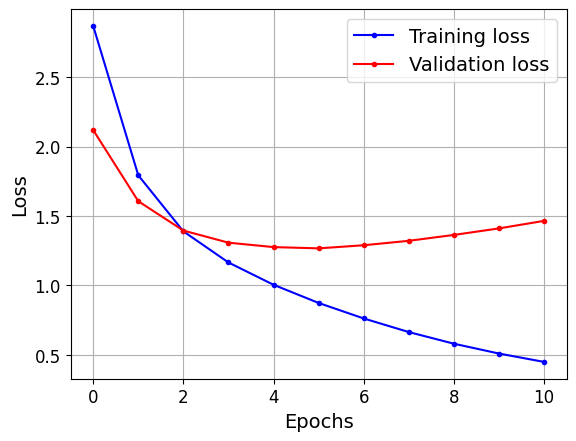

In [45]:
import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)), loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)), val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    # plt.axis([1, len(history.epoch), 0.1, 0.15])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [52]:
# Definir una función que realice la traducción utilizando el modelo entrenado previamente

def translate(sentence_en):
    translation = ""  # Inicializa la traducción como una cadena vacía

    # Itera sobre cada palabra hasta alcanzar la longitud máxima definida
    for word_idx in range(max_length):
        X = np.array([sentence_en])  # Prepara la entrada del codificador con la frase en inglés
        X_dec = np.array(["startofseq " + translation])  # Prepara la entrada del decodificador con la traducción parcial

        # Predice las probabilidades del siguiente token utilizando el modelo
        y_proba = model.predict((X, X_dec),verbose=0)[0, word_idx]  # Obtiene las probabilidades del último token predicho
        predicted_word_id = np.argmax(y_proba)  # Obtiene el ID de la palabra predicha con mayor probabilidad
        predicted_word = text_vec_layer_es.get_vocabulary()[predicted_word_id]  # Obtiene la palabra correspondiente al ID

        # Si la palabra predicha es "endofseq", termina la traducción
        if predicted_word == "endofseq":
            break

        # Agrega la palabra predicha a la traducción
        translation += " " + predicted_word

    # Retorna la traducción final sin espacios adicionales al inicio y final
    return translation.strip()

In [53]:
translate("I like soccer")

'me gusta el fútbol'

In [55]:
translate("I like going to the beach")

'me gusta ir a la playa'

In [54]:
translate("I like soccer and also going to the beach")

'me gusta viajar en la playa y a la playa'

In [57]:
translate("This translator works very well")

'este trabajo puede muy bien'

¿Cómo se puede mejorar? Una forma es aumentar el tamaño del conjunto de entrenamiento y añadir más capas LSTM tanto en el codificador como en el decodificador. Pero esto no es suficiente, así que veamos técnicas más sofisticadas, empezando por las capas recurrentes bidireccionales.

# Redes recurrentes Bidireccionales

Una capa recurrente bidireccional, como la `tf.keras.layers.Bidirectional` en TensorFlow, es una variante de las capas recurrentes diseñada para capturar información contextual tanto de las secuencias pasadas como de las futuras en datos secuenciales.

### Capas Recurrentes Bidireccionales

Las capas recurrentes bidireccionales procesan la secuencia de entrada en dos direcciones simultáneamente:

1. **Dirección directa**: Procesa la secuencia de izquierda a derecha como una capa recurrente unidireccional normal.
   
2. **Dirección inversa**: Procesa la secuencia en orden inverso, de derecha a izquierda.

### Funcionamiento de la Capa Bidireccional

- **Entrada**: Para cada paso de tiempo en la secuencia de entrada, la capa bidireccional recibe dos entradas:
  - La entrada directa normal.
  - La entrada inversa, que es la secuencia original invertida.

- **Salida**: En cada paso de tiempo, la capa bidireccional produce dos salidas:
  - Una salida que representa el procesamiento de la secuencia en orden directo.
  - Otra salida que representa el procesamiento de la secuencia en orden inverso.

- **Combinación de Salidas**: Las salidas de ambas direcciones se combinan de alguna manera (generalmente concatenándolas) antes de pasarlas a la siguiente capa en la red neuronal. Esto permite que la red capture dependencias de contexto tanto hacia atrás como hacia adelante en la secuencia de entrada.

In [58]:
tf.random.set_seed(42)

# Definir una capa LSTM bidireccional con 256 unidades y configurada para devolver el estado interno
encoder = tf.keras.layers.Bidirectional(
    tf.keras.layers.LSTM(256, return_state=True))

In [59]:
# Aplicar la capa LSTM bidireccional al embedding del codificador para obtener las salidas y los estados
encoder_outputs, *encoder_state = encoder(encoder_embeddings)

# Concatena los estados de la capa LSTM bidireccional para formar los estados finales
encoder_state = [
    tf.concat(encoder_state[::2], axis=-1),   # Combina los estados de corto plazo (0 y 2)
    tf.concat(encoder_state[1::2], axis=-1)   # Combina los estados de largo plazo (1 y 3)
]

**Nota**: la siguiente celda tardará un rato en ejecutarse (posiblemente un par de horas si no utilizas una GPU).

In [60]:
# Definir la capa LSTM para el decodificador
decoder = tf.keras.layers.LSTM(512, return_sequences=True)

# Aplicar la capa LSTM al embedding del decodificador, utilizando el estado inicial del codificador
decoder_outputs = decoder(decoder_embeddings, initial_state=encoder_state)

# Definir la capa de salida con activación softmax para generar las probabilidades de las palabras en el vocabulario
output_layer = tf.keras.layers.Dense(vocab_size, activation="softmax")
Y_proba = output_layer(decoder_outputs)

# Definir el modelo de Keras con las entradas del codificador y decodificador, y la salida de Y_proba
model = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs], outputs=[Y_proba])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
history = model.fit((X_train, X_train_dec), Y_train, epochs=10, validation_data=((X_valid, X_valid_dec), Y_valid),
          callbacks=[early_stopping])

Epoch 1/10
3125/3125 [==============================] - 132s 37ms/step - loss: 2.1253 - accuracy: 0.5468 - val_loss: 1.5099 - val_accuracy: 0.6396
Epoch 2/10
3125/3125 [==============================] - 87s 28ms/step - loss: 1.3134 - accuracy: 0.6758 - val_loss: 1.2979 - val_accuracy: 0.6774
Epoch 3/10
3125/3125 [==============================] - 87s 28ms/step - loss: 1.0954 - accuracy: 0.7180 - val_loss: 1.2157 - val_accuracy: 0.6972
Epoch 4/10
3125/3125 [==============================] - 112s 36ms/step - loss: 0.9478 - accuracy: 0.7481 - val_loss: 1.1877 - val_accuracy: 0.7023
Epoch 5/10
3125/3125 [==============================] - 105s 34ms/step - loss: 0.8279 - accuracy: 0.7738 - val_loss: 1.1902 - val_accuracy: 0.7028
Epoch 6/10
3125/3125 [==============================] - 105s 33ms/step - loss: 0.7253 - accuracy: 0.7973 - val_loss: 1.2158 - val_accuracy: 0.7010
Epoch 7/10
3125/3125 [==============================] - 99s 32ms/step - loss: 0.6380 - accuracy: 0.8179 - val_loss: 1.24

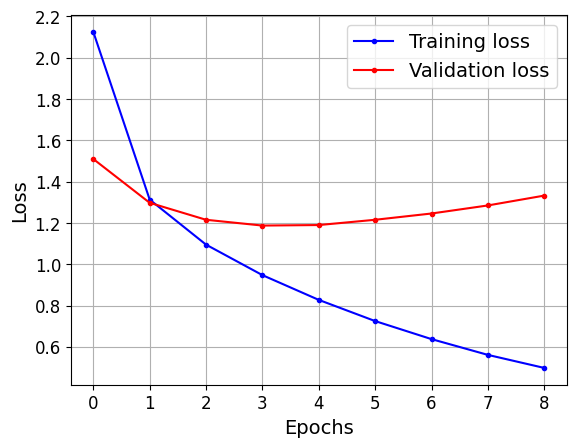

In [61]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [62]:
translate("I like soccer")

'me gusta el fútbol'

In [63]:
translate("I like going to the beach")

'me gusta ir a la playa'

In [64]:
translate("I like soccer and also going to the beach")

'me gusta el mismo y prefiero ir al colegio'

In [65]:
translate("This translator works very well")

'este [UNK] funciona muy bien'

### Guardar el modelo


In [49]:
from google.colab import drive

# Monta Google Drive
drive.mount('/content/drive')

In [50]:
# Define la ruta donde deseas guardar el modelo
model_path = "/content/drive/MyDrive/traductor/"

# Guarda el modelo
model.save(model_path)

### Cargar el modelo

In [51]:
# # Carga el modelo
# model = tf.keras.models.load_model(model_path)

# # Ejemplo de uso
# sentence_to_translate = "I enjoy eating."
# translated_sentence = translate(sentence_to_translate)
# print(f"Texto original: {sentence_to_translate}")
# print(f"Traducción: {translated_sentence}")